In [ ]:
#Copy google drive directoy to current environment

%cp -av /content/drive/MyDrive/Dissertation/Data/20230530/train/ /content/train/

'/content/drive/MyDrive/Dissertation/Data/20230530/train/' -> '/content/train/'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-10.jpg' -> '/content/train/A30H100-0602-10.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-01.jpg' -> '/content/train/A30H100-0602-01.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-04.jpg' -> '/content/train/A30H100-0602-04.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-05.jpg' -> '/content/train/A30H100-0602-05.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-02.jpg' -> '/content/train/A30H100-0602-02.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-13.jpg' -> '/content/train/A30H100-0602-13.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-11.jpg' -> '/content/train/A30H100-0602-11.jpg'
'/content/drive/MyDrive/Dissertation/Data/20230530/train/A30H100-0602-08.jpg' -> '/content/tra

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15253, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 15253 (delta 143), reused 181 (delta 105), pack-reused 14979
Receiving objects: 100% (15253/15253), 6.28 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (11010/11010), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
#Directly use COCO annotation
from detectron2.data.datasets import register_coco_instances

#batch_list=['20230523','20230526','20230530','20230602','20230720']
batch_list=['20230523','20230526','20230530','20230720']
#batch_list=['20230523','20230526','20230530']
sub_batch_list=['A0H100','A0H50','A30H100','A30H50']
#sub_batch_list=['A0H50','A30H50']

#DatasetCatalog.remove('20230526_A0H100_train')
#For Glasshouse images
for d in ["train", "val"]:
    for bl in batch_list:
      for sbl in sub_batch_list:
        register_coco_instances(sbl+'_'+bl+'_'+d, {}, 'annotation_'+sbl+'_'+bl+'_'+d+'.json', "/content/train/withSoilMask")
        #register_coco_instances(sbl+'_'+bl+'_'+d, {}, 'annotation_'+sbl+'_'+bl+'_'+d+'.json', "/content/train")
        metadata = MetadataCatalog.get(sbl+'_'+bl+'_'+d)
        print(metadata)

#For Field images
#register_coco_instances('A0H50_20230720_train', {}, 'annotation_'+'A0H50_20230720_train'+'.json', "/content/train/withSoilMask")
#register_coco_instances('A0H50_20230720_val', {}, 'annotation_'+'A0H50_20230720_val'+'.json', "/content/train/withSoilMask")
#register_coco_instances('A0H50_20230720_train', {}, 'annotation_'+'A0H50_20230720_train'+'.json', "/content/train")
#register_coco_instances('A0H50_20230720_val', {}, 'annotation_'+'A0H50_20230720_val'+'.json', "/content/train")

%cd '/content/train'

Metadata(name='A0H100_20230523_train', json_file='annotation_A0H100_20230523_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A0H50_20230523_train', json_file='annotation_A0H50_20230523_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A30H100_20230523_train', json_file='annotation_A30H100_20230523_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A30H50_20230523_train', json_file='annotation_A30H50_20230523_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A0H100_20230526_train', json_file='annotation_A0H100_20230526_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A0H50_20230526_train', json_file='annotation_A0H50_20230526_train.json', image_root='/content/train/withSoilMask', evaluator_type='coco')
Metadata(name='A30H100_20230526_train', json_file='annotation_A30H100_20

In [ ]:
%cd '/content/train'

/content/train


[09/16 06:40:54 d2.data.datasets.coco]: Loaded 20 images in COCO format from annotation_A30H50_20230526_val.json


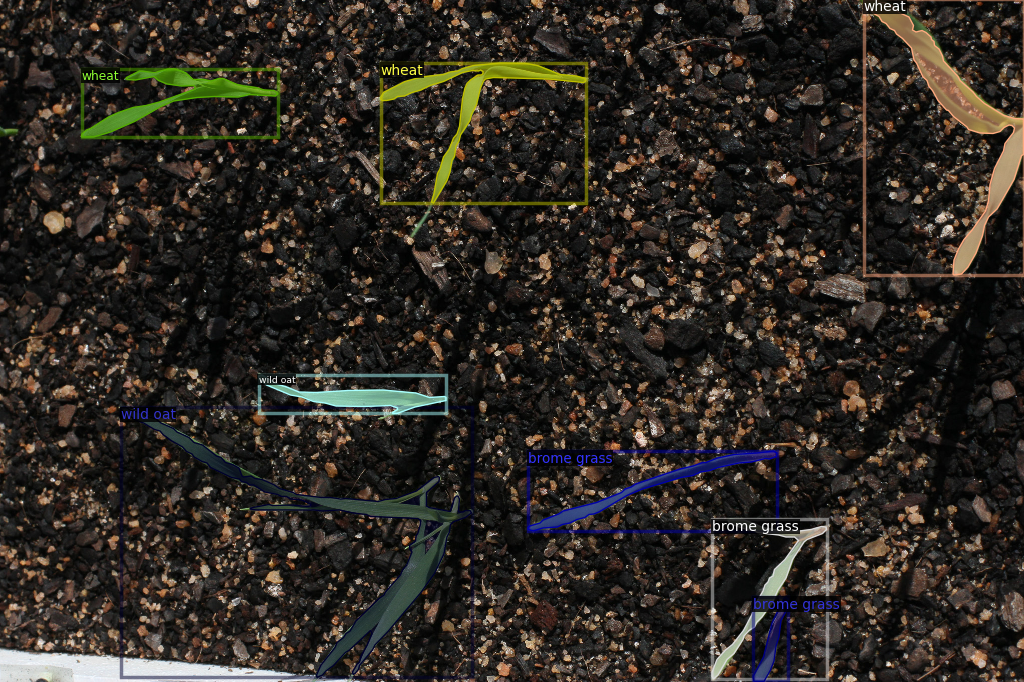

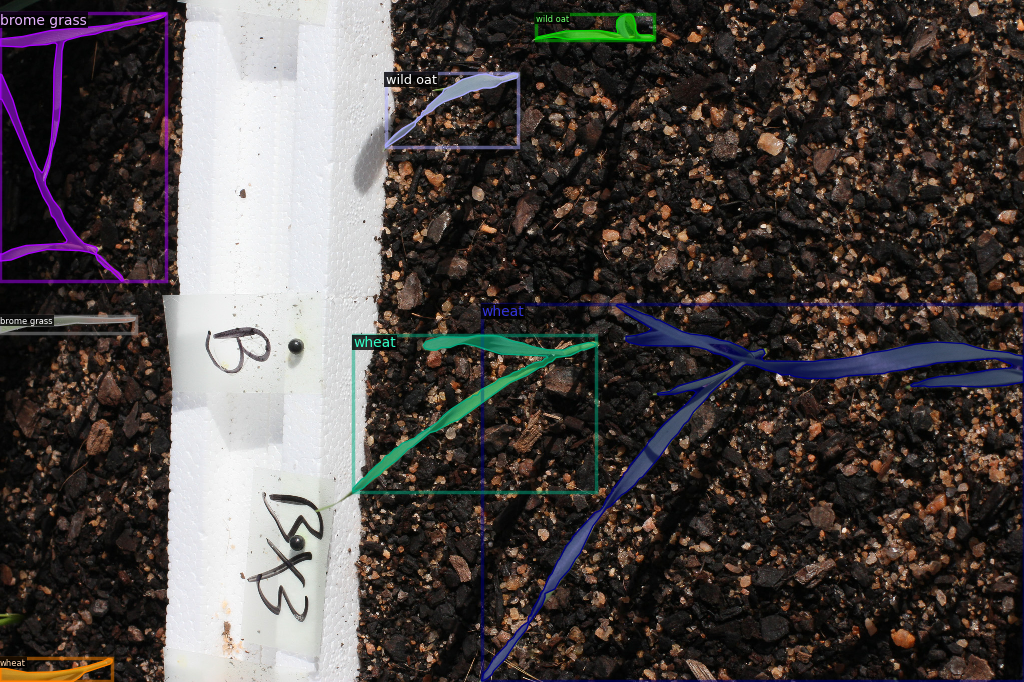

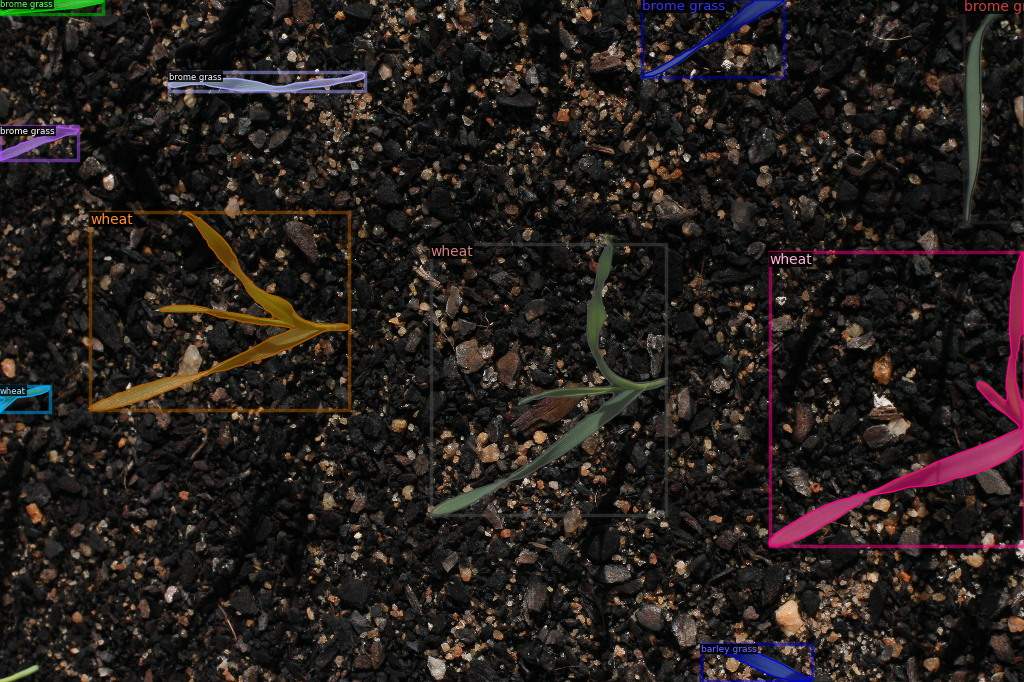

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

train_metadata_20230530 = MetadataCatalog.get("A30H50_20230526_val")
train_dicts_20230530 = DatasetCatalog.get("A30H50_20230526_val")

for d in random.sample(train_dicts_20230530, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata_20230530, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

dataset_train_list=[]
#For glasshouse
for bl in batch_list:
  for sbl in sub_batch_list:
    dataset_train_list.append(sbl+'_'+bl+'_train')
#For field
#dataset_train_list.append('A0H50_20230720_train')
print(dataset_train_list)

dataset_val_list=[]
for blv in batch_list:
  for sblv in sub_batch_list:
    dataset_val_list.append(sblv+'_'+blv+'_val')
print(dataset_val_list)

cfg.DATASETS.TRAIN = tuple(dataset_train_list)
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.25
cfg.DATASETS.TEST = ()
#cfg.DATASETS.TEST = tuple(dataset_val_list)
cfg.TEST.EVAL_PERIOD =  20
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 90000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.



['A0H100_20230523_train', 'A0H50_20230523_train', 'A30H100_20230523_train', 'A30H50_20230523_train', 'A0H100_20230526_train', 'A0H50_20230526_train', 'A30H100_20230526_train', 'A30H50_20230526_train', 'A0H100_20230530_train', 'A0H50_20230530_train', 'A30H100_20230530_train', 'A30H50_20230530_train', 'A0H100_20230720_train', 'A0H50_20230720_train', 'A30H100_20230720_train', 'A30H50_20230720_train']
['A0H100_20230523_val', 'A0H50_20230523_val', 'A30H100_20230523_val', 'A30H50_20230523_val', 'A0H100_20230526_val', 'A0H50_20230526_val', 'A30H100_20230526_val', 'A30H50_20230526_val', 'A0H100_20230530_val', 'A0H50_20230530_val', 'A30H100_20230530_val', 'A30H50_20230530_val', 'A0H100_20230720_val', 'A0H50_20230720_val', 'A30H100_20230720_val', 'A30H50_20230720_val']


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_test_loader, build_detection_train_loader   # the default mapper
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
      return build_detection_train_loader(cfg,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
             # T.Resize((819, 1229)),
              #T.Resize((518, 778)),
              T.Resize((400, 600)),
              #T.RandomBrightness(0.8, 1.8),
             T.RandomApply(T.RandomBrightness(0.5, 1.5),prob=0.7),
              #T.RandomContrast(0.6, 1.3),
             T.RandomApply(T.RandomContrast(0.4, 0.8),prob=0.7),
            # T.RandomSaturation(0.8, 1.4),
              T.RandomApply(T.RandomRotation(angle=[-10,10]),prob=0.7),
            #  T.RandomLighting(0.7),
             # T.RandomFlip(prob=0.5, horizontal=False, vertical=True)
        ]))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
          output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")

        return COCOEvaluator(dataset_name, cfg, True, output_folder)

[08/15 12:53:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

ValueError: ignored

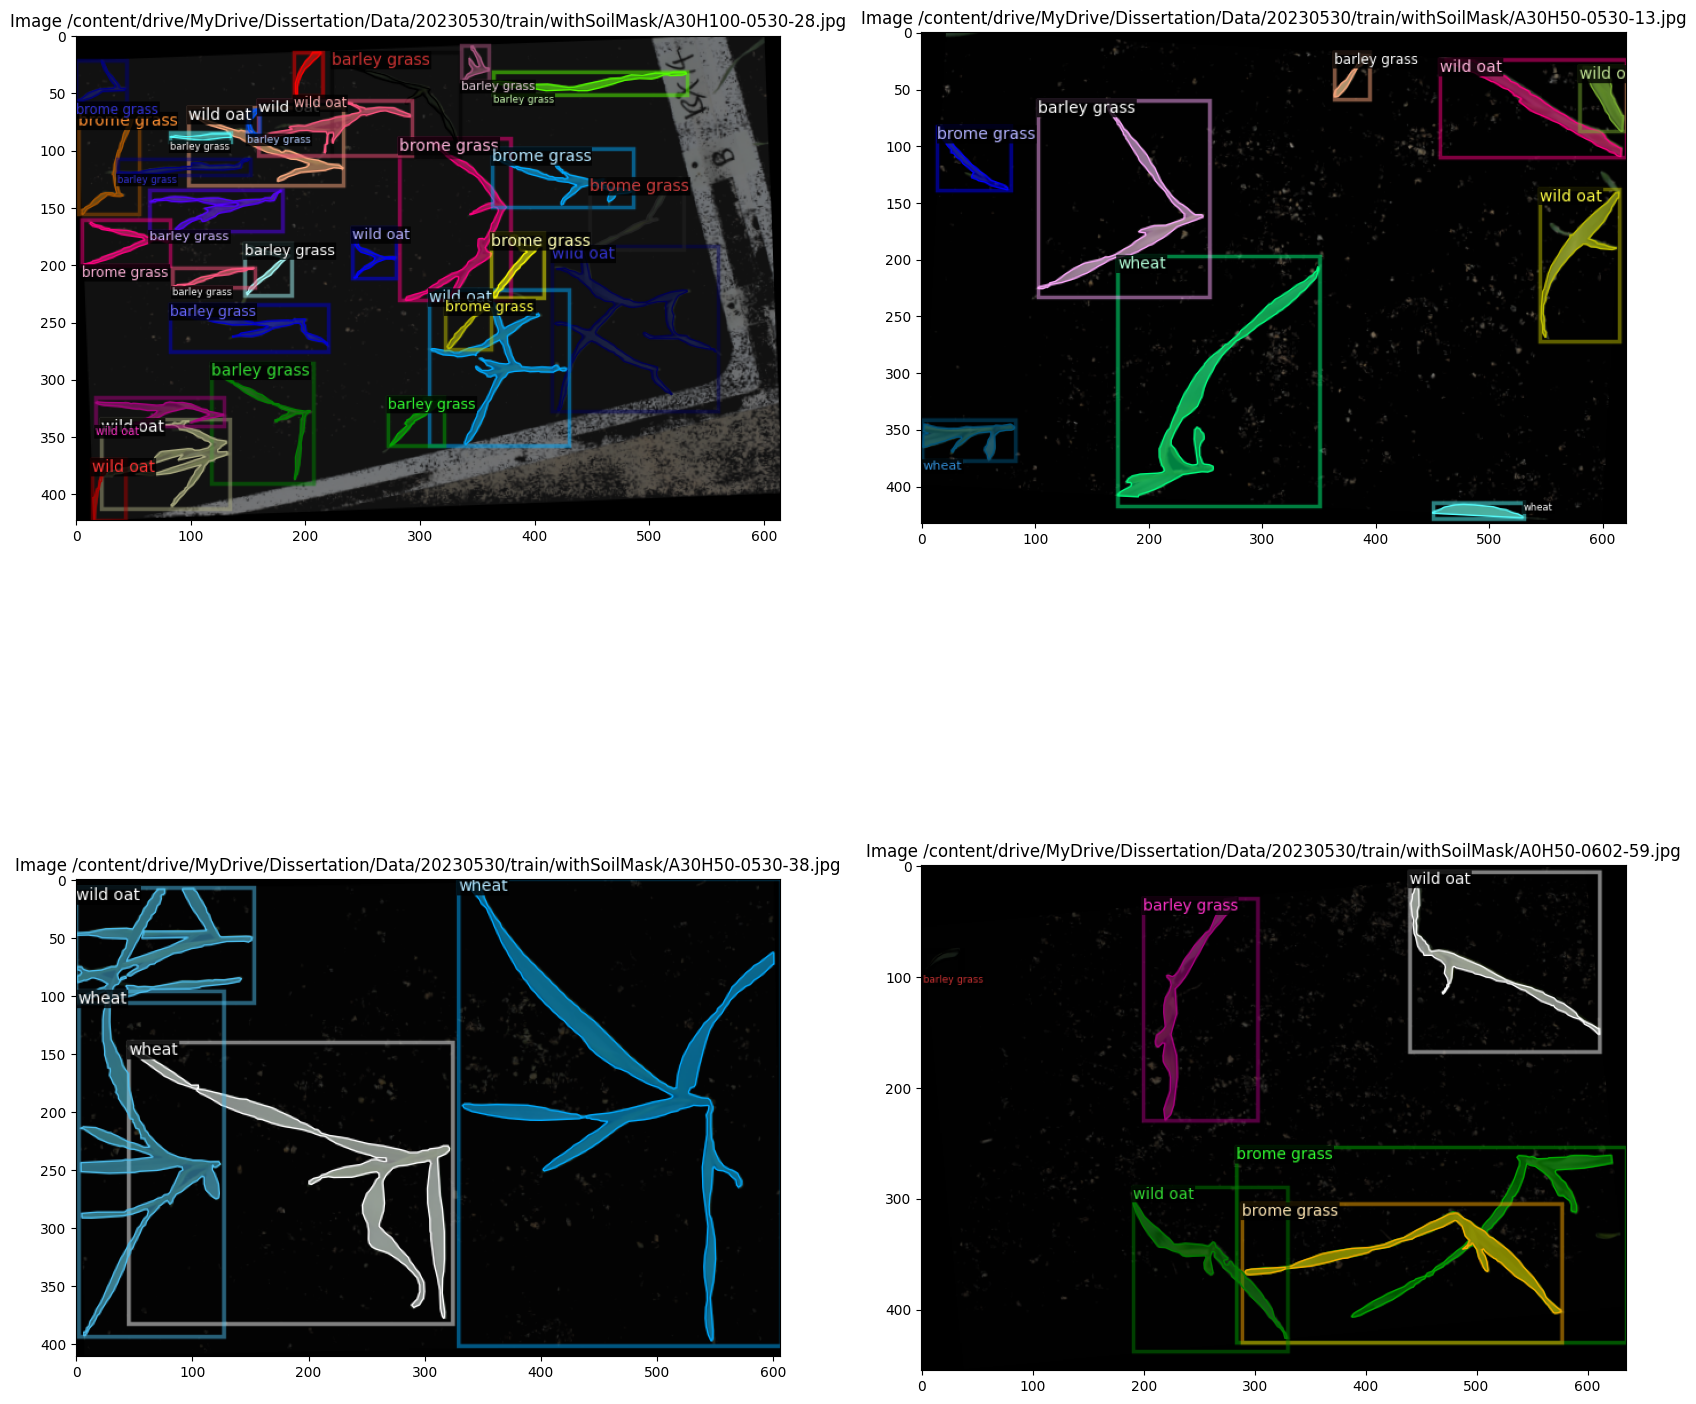

In [ ]:
##Visualise augmentations
from matplotlib import pyplot as plt
Temptrainer = CustomTrainer(cfg)
loader = Temptrainer.build_train_loader(cfg)
sample_image_batches = 2
f = plt.figure(figsize=(20, 10 * sample_image_batches))
idx = 1

for sample_image_batch_idx, train_image_batch in enumerate(loader):

    for idx, train_image in enumerate(train_image_batch):
        image = train_image["image"].numpy().transpose(1, 2, 0)

        target_fields = train_image["instances"].get_fields()
        labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]]

        # visualize ground truth
        gt_visualizer = Visualizer(
            image[:, :, ::-1], metadata=metadata, scale=1
        )
        gt_image_vis = gt_visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )

        #f.add_subplot(sample_image_batches, 2, (2 * sample_image_batch_idx) + idx + 1)
        f.add_subplot(sample_image_batches, 2, (2 * sample_image_batch_idx) + idx + 1)
        plt.title(f"Image {train_image['file_name']}")
        plt.imshow(gt_image_vis.get_image())#[:, :, ::-1])

    if sample_image_batch_idx >= sample_image_batches -1:
        break
plt.show()

In [ ]:
#from detectron2.engine import DefaultTrainer
import time

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import locale
locale.getpreferredencoding = lambda: "UTF-8"
%cp /content/train/output/model_final.pth /content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230922_2/
%cp /content/train/output/metrics.json /content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230922_2/
%cp /content/train/output/last_checkpoint /content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230922_2/

time.sleep(60)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

Fri Jun 30 15:33:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |  15025MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
model_path='/content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230818_1'
#model_path='/content/train/output'
#model_name='20230809_2.pth'
model_name='model_final.pth'
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/19 00:35:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230818_1/model_final.pth ...


Test with resized image for prediction

[08/10 07:55:03 d2.data.datasets.coco]: Loaded 76 images in COCO format from annotation_A0H50_20230526_train.json
{'file_name': '/content/drive/MyDrive/Dissertation/Data/20230530/train/A0H50-0526-44.jpg', 'height': 1365, 'width': 2048, 'image_id': 92, 'annotations': [{'iscrowd': 0, 'bbox': [79.0, 0.0, 630.0, 578.0], 'category_id': 0, 'segmentation': [[709.0, 0.0, 674.0, 0.0, 672.0, 5.0, 661.0, 10.0, 641.0, 29.0, 634.0, 33.0, 606.0, 63.0, 601.0, 64.0, 586.0, 78.0, 569.0, 86.0, 555.0, 96.0, 499.0, 144.0, 472.0, 180.0, 451.0, 201.0, 442.0, 206.0, 407.0, 245.0, 388.0, 284.0, 382.0, 311.0, 382.0, 334.0, 379.0, 337.0, 369.0, 336.0, 351.0, 327.0, 330.0, 321.0, 305.0, 322.0, 289.0, 330.0, 288.0, 332.0, 290.0, 334.0, 309.0, 333.0, 356.0, 347.0, 372.0, 347.0, 374.0, 354.0, 336.0, 392.0, 298.0, 433.0, 290.0, 445.0, 258.0, 477.0, 208.0, 510.0, 159.0, 528.0, 138.0, 533.0, 101.0, 549.0, 79.0, 570.0, 80.0, 576.0, 84.0, 578.0, 107.0, 576.0, 131.0, 567.0, 162.0, 551.0, 218.0, 513.0, 230.0, 511.0, 236.0

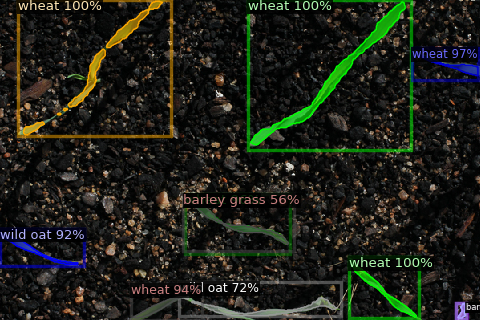

In [ ]:
from detectron2.utils.visualizer import ColorMode

batch_list=['20230526']
#sub_batch_list=['A0H100','A0H50','A30H100','A30H50']
sub_batch_list=['A0H50']

val_metadata_20230530 = MetadataCatalog.get("A0H50_20230526_train")
val_dicts_20230530 = DatasetCatalog.get("A0H50_20230526_train")

for d in val_dicts_20230530:
  tmpFileName = 'A0H50-0526-44.jpg'
  if tmpFileName in d["file_name"]:
      print(d)
      d["file_name"] = '/content/drive/MyDrive/Dissertation/Data/20230530/train/testImg/' + tmpFileName
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
                    metadata=val_metadata_20230530,
                    scale=0.8,
                    instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(v.get_image()[:, :, ::-1])


Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

val_metadata_20230530 = MetadataCatalog.get("A0H50_20230720_val")
val_dicts_20230530 = DatasetCatalog.get("A0H50_20230720_val")
for d in random.sample(val_dicts_20230530, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_20230530,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
# Evaluate the model
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.INPUT.MAX_SIZE_TEST = 1333
predictor = DefaultPredictor(cfg)
#predictor = CustomPredictor(cfg)

#trainer = CustomTrainer(cfg)
#trainer.test(cfg, trainer.model)

dataSet_val = "A0H50_20230530_val"

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator(dataSet_val, cfg, False, output_dir="./output/")
#val_loader = build_detection_test_loader(cfg, dataSet_val)
val_loader = build_detection_test_loader(cfg, dataSet_val, mapper=DatasetMapper(cfg, is_train=False, augmentations=[T.Resize((400, 600))]))

#Use the created predicted model in the previous step
#inference_on_dataset(trainer.model, val_loader, evaluator)
inference_on_dataset(predictor.model, val_loader, evaluator)

[08/19 00:52:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dissertation/Data/20230530/Archive/20230818_1/model_final.pth ...
[08/19 00:52:30 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [08/19 00:52:30 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/19 00:52:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [Resize(shape=(400, 600))]
[08/19 00:52:30 d2.data.datasets.coco]: Loaded 20 images in COCO format from annotation_A0H50_20230530_val.json
[08/19 00:52:30 d2.data.build]: Distribution of instances among all 4 categories:
|   category   | #instances   |  category  | #instances   |  category   | #instances   |
|:------------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|    wheat     | 12           |  wild oat  | 57  

OrderedDict([('bbox',
              {'AP': 42.23835737251231,
               'AP50': 53.617560366008135,
               'AP75': 48.76787876848866,
               'APs': 0.0,
               'APm': 45.285905925757405,
               'APl': 41.78924202313969,
               'AP-wheat': 41.58605498558906,
               'AP-wild oat': 43.77005125765659,
               'AP-brome grass': 32.80383778337489,
               'AP-barley grass': 50.79348546342873}),
             ('segm',
              {'AP': 25.81893765900557,
               'AP50': 49.404632975641036,
               'AP75': 22.6630269700452,
               'APs': 49.99999999999999,
               'APm': 29.997275311322337,
               'APl': 23.323424393746233,
               'AP-wheat': 14.84818481848185,
               'AP-wild oat': 32.52903927519543,
               'AP-brome grass': 25.727328481977118,
               'AP-barley grass': 30.17119806036787})])